In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet as df_prophet

In [ ]:
pip install prophet

In [2]:
# Cargar dataset con fechas como índice
df = pd.read_csv('METR-LA.csv', index_col=0, parse_dates=True, low_memory=False)
# Mostrar las primeras filas del DataFrame correctamente
print(df.head())


                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000  64.500  64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000   0.000   0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000   0.000   0.000   0.000000   0.000000  ...   

                        772167  769372     774204     769806  717590

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34272 entries, 2012-03-01 00:00:00 to 2012-06-27 23:55:00
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 54.4 MB
None
             773869        767541        767542        717447        717446  \
count  34272.000000  34272.000000  34272.000000  34272.000000  34272.000000   
mean      54.631359     60.452789     60.726120     49.524287     46.079798   
std       22.619199     15.970239     18.313353     15.843261     19.350345   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       60.364583     63.000000     65.444444     50.333333     34.666667   
50%       64.888889     65.000000     67.375000     53.875000     46.000000   
75%       66.875000     66.375000     68.444444     58.125000     64.500000   
max       70.000000     70.000000     70.000000     70.000000     70.000000   

             717445        773062        767620        737529        717816  \
count  3427

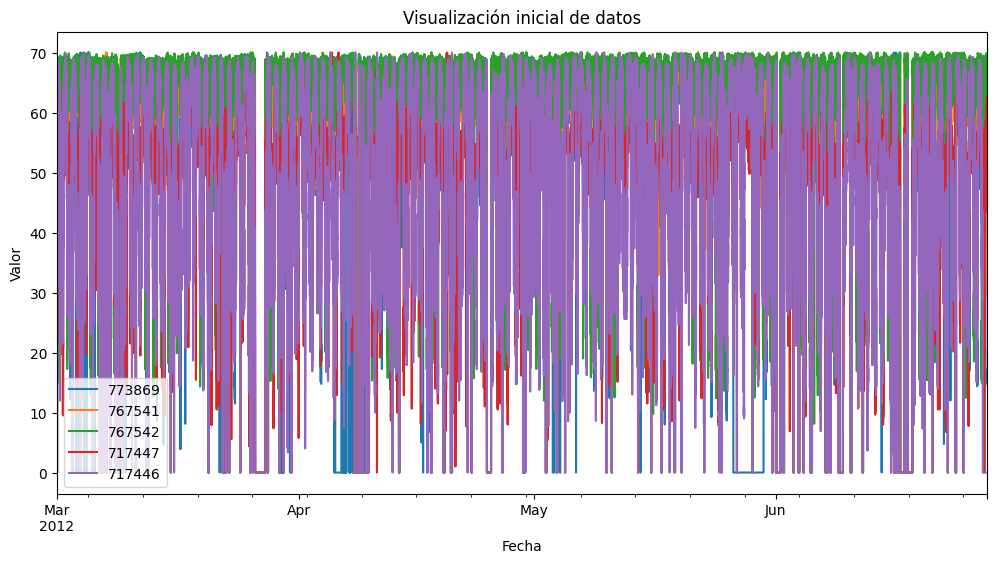

In [3]:
# Verificación de datos
def explore_data(df):
    print(df.info())
    print(df.describe())
    df.iloc[:, :5].plot(figsize=(12,6))  # Graficar las primeras 5 columnas
    plt.title("Visualización inicial de datos")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.show()

explore_data(df)

In [4]:
# Preprocesamiento
df.replace(0, np.nan, inplace=True)
#Eliminar columnas con más del 50% de valores faltantes
df.dropna(axis=1, thresh=len(df)*0.5, inplace=True)
#Imputar valores faltantes con interpolación temporal y relleno
df.interpolate(method='linear', inplace=True)  # Más estable que 'time' en series con ruido
df.fillna(method='ffill', inplace=True) # Forward fill para estabilidad
df.fillna(method='bfill', inplace=True) # Backward fill en caso de valores iniciales NaN


/var/folders/rc/f21g1mws1mqb8xvz6f0j1yd40000gn/T/ipykernel_67980/3758938321.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # Forward fill para estabilidad
/var/folders/rc/f21g1mws1mqb8xvz6f0j1yd40000gn/T/ipykernel_67980/3758938321.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True) # Backward fill en caso de valores iniciales NaN


In [5]:

# Detección y eliminación de outliers (percentil 1-99%)
for col in df.columns:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower_bound, upper_bound)

In [6]:
# Normalización con StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)


# FFNN

Primero, vamos a crear sliding windows para convertir la serie temporal en un problema supervisado

In [7]:
def create_dataset(data, look_back, future_steps):
    X, y = [], []
    for i in range(len(data) - look_back - future_steps):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back:i + look_back + future_steps])
    return np.array(X), np.array(y)

look_back = 12  # Número de pasos anteriores para usar como input
future_steps = 6  # Predecir los próximos 3 pasos

In [8]:
X, y = create_dataset(df_scaled, look_back, future_steps)

In [9]:
# Dividir en entrenamiento y prueba (80% - 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Aplanar los datos para que el modelo FFNN los acepte
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

In [10]:
print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")

Forma de X_train: (27403, 2484), y_train: (27403, 1242)


Esto permitirá que el modelo FFNN tome múltiples puntos de datos para predecir múltiples valores futuros.

Vamos a definir un modelo FFNN usando TensorFlow con las siguientes capas:
- Entrada – look_back como tamaño de entrada.
- Capas densas (Dense) – Con activación ReLU para modelar relaciones no lineales.
- Salida – future_steps para predecir múltiples pasos hacia adelante.

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization, ELU, Dropout

output_dim = y_train.shape[1]
# Definir el modelo
model_ffnn = models.Sequential([
    # Primera capa
    layers.Dense(64, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    ELU(),

    # Segunda capa
    layers.Dense(64),
    BatchNormalization(),
    ELU(),

    # Capa de salida
    layers.Dense(output_dim)  # Sin activación para regresión
])

# Compilar el modelo
model_ffnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='mse',
                   metrics=['mae'])

model_ffnn.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       159,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1242)           │        80,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,442 (954.85 KB)

 Trainable params: 244,186 (953.85 KB)

 Non-trainable params: 256 (1.00 KB)

- 64 neuronas – Tamaño típico para problemas de series temporales.
- ReLU – Función de activación para capturar no linealidades.
- Adam – Optimizador adaptativo eficiente.
- MSE – Pérdida adecuada para regresión.

Ahora, entrenamos el modelo con:
- batch_size = 32 – Tamaño de lote estándar.
- epochs = 50 – Número razonable de épocas para convergencia.
- validation_split = 0.1 – Separa un 10% de los datos de entrenamiento para validación.

In [12]:
history = model_ffnn.fit(X_train, y_train,
                          epochs=50,
                          batch_size=32,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5523 - mae: 0.4877 - val_loss: 0.3607 - val_mae: 0.3747
Epoch 2/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3939 - mae: 0.4147 - val_loss: 0.3388 - val_mae: 0.3616
Epoch 3/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3702 - mae: 0.4020 - val_loss: 0.3328 - val_mae: 0.3603
Epoch 4/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3587 - mae: 0.3970 - val_loss: 0.3252 - val_mae: 0.3571
Epoch 5/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3517 - mae: 0.3933 - val_loss: 0.3270 - val_mae: 0.3622
Epoch 6/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3488 - mae: 0.3916 - val_loss: 0.3218 - val_mae: 0.3538
Epoch 7/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3459 - mae: 0.3902 - val_loss: 0.3205 - val_mae: 0.3541
Epoch 8/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3420 - mae: 0.3885 - val_loss: 0.3198 - val_mae: 0.3560
Epoch 9/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

Ahora evaluamos el modelo en el conjunto de prueba:

In [13]:
loss, mae = model_ffnn.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {loss:.4f}')
print(f'Test MAE: {mae:.4f}')

Test Loss (MSE): 0.3850
Test MAE: 0.4071


Predecimos valores futuros usando el modelo entrenado:

In [14]:
predictions = model_ffnn.predict(X_test)

# Dividir las predicciones para obtener valores específicos (5, 15, 30 minutos)
pred_5 = predictions[:, 0]
pred_15 = predictions[:, 2]
pred_30 = predictions[:, 5]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Número de pasos futuros y sensores
future_steps = 6
n_sensors = 207

# Si las predicciones están aplanadas, reformarlas en 3D
predictions = predictions.reshape(predictions.shape[0], future_steps, n_sensors)
y_test = y_test.reshape(y_test.shape[0], future_steps, n_sensors)

# Reshape a 2D para poder aplicar el scaler.inverse_transform
predictions_reshaped = predictions.reshape(-1, n_sensors)
y_test_reshaped = y_test.reshape(-1, n_sensors)

# Invertir la escala
predictions_original = scaler.inverse_transform(predictions_reshaped)
y_test_original = scaler.inverse_transform(y_test_reshaped)

# Volver a 3D para coincidir con la estructura original
predictions_original = predictions_original.reshape(predictions.shape[0], future_steps, n_sensors)
y_test_original = y_test_original.reshape(y_test.shape[0], future_steps, n_sensors)

# Extraer las predicciones para los horizontes de 5, 15 y 30 minutos
pred_5 = predictions_original[:, 0]     # Primer horizonte (5 minutos)
pred_15 = predictions_original[:, 2]    # Tercer horizonte (15 minutos)
pred_30 = predictions_original[:, 5]    # Sexto horizonte (30 minutos)

# Calcular RMSE y MAE en la escala original
mse_5 = mean_squared_error(y_test_original[:, 0], pred_5)
mae_5 = mean_absolute_error(y_test_original[:, 0], pred_5)

mse_15 = mean_squared_error(y_test_original[:, 2], pred_15)
mae_15 = mean_absolute_error(y_test_original[:, 2], pred_15)

mse_30 = mean_squared_error(y_test_original[:, 5], pred_30)
mae_30 = mean_absolute_error(y_test_original[:, 5], pred_30)

# Imprimir resultados
print(f"5 minutos -> RMSE: {mse_5:.4f}, MAE: {mae_5:.4f}")
print(f"15 minutos -> RMSE: {mse_15:.4f}, MAE: {mae_15:.4f}")
print(f"30 minutos -> RMSE: {mse_30:.4f}, MAE: {mae_30:.4f}")


5 minutos -> RMSE: 30.2684, MAE: 3.5272
15 minutos -> RMSE: 35.2946, MAE: 3.7071
30 minutos -> RMSE: 42.8061, MAE: 3.9835


In [16]:
# Seleccionar sensores específicos para el análisis
selected_sensors = [0, 1, 2, 3, 4, 5]  # Ejemplo: los primeros 6 sensores

# Crear una tabla para almacenar resultados
results = []

# Calcular el MSE para cada paso y sensor en la escala original
for step in range(future_steps):
    row = [step + 1]  # Paso empieza en 1
    for sensor in selected_sensors:
        mse = mean_squared_error(y_test_original[:, step, sensor], predictions_original[:, step, sensor])
        row.append(round(mse, 4))  # Más precisión para el reporte
    results.append(row)

# Crear un DataFrame para mostrar resultados
columns = ['Horizon (steps)'] + [f'Sensor {i+1}' for i in range(len(selected_sensors))]
df_results = pd.DataFrame(results, columns=columns)

# Mostrar resultados
print(df_results)

   Horizon (steps)  Sensor 1  Sensor 2  Sensor 3  Sensor 4  Sensor 5  Sensor 6
0                1   26.9687    4.7776   17.2838   21.4314   31.9576   38.6789
1                2   28.8905    4.7881   17.7202   22.6959   35.6314   41.0853
2                3   32.0459    4.8624   18.5308   24.9297   38.0564   43.3163
3                4   35.1785    4.8470   19.5854   27.0236   40.0465   46.4951
4                5   37.8133    4.8585   20.7554   29.0532   41.9821   48.5661
5                6   40.7022    4.8775   21.9629   30.6096   43.9577   50.6547


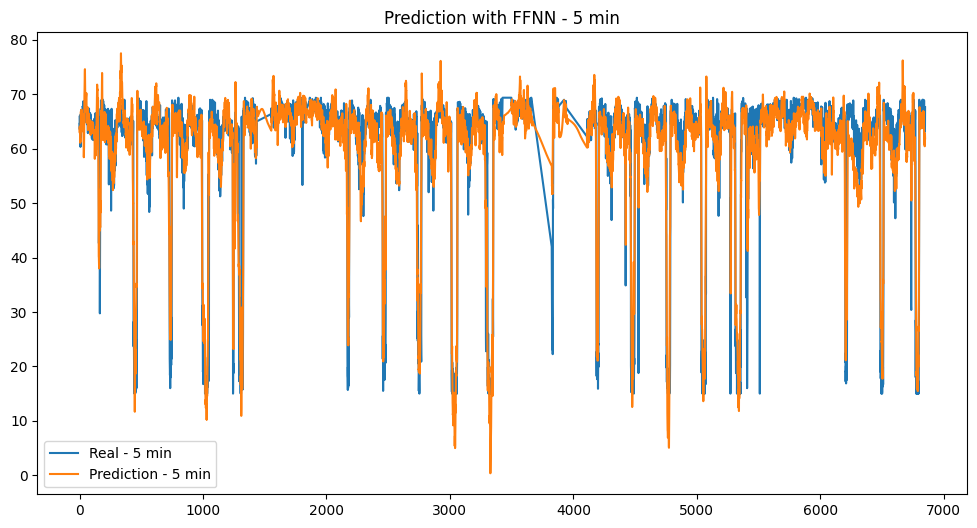

In [20]:
import matplotlib.pyplot as plt

# Graficar predicciones después de la transformación inversa

plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:, 0, 0], label='Real - 5 min')  # Sensor 1, horizonte 5 minutos
plt.plot(pred_5[:, 0], label='Prediction - 5 min')
plt.title('Prediction with FFNN - 5 min')
plt.legend()
plt.show()

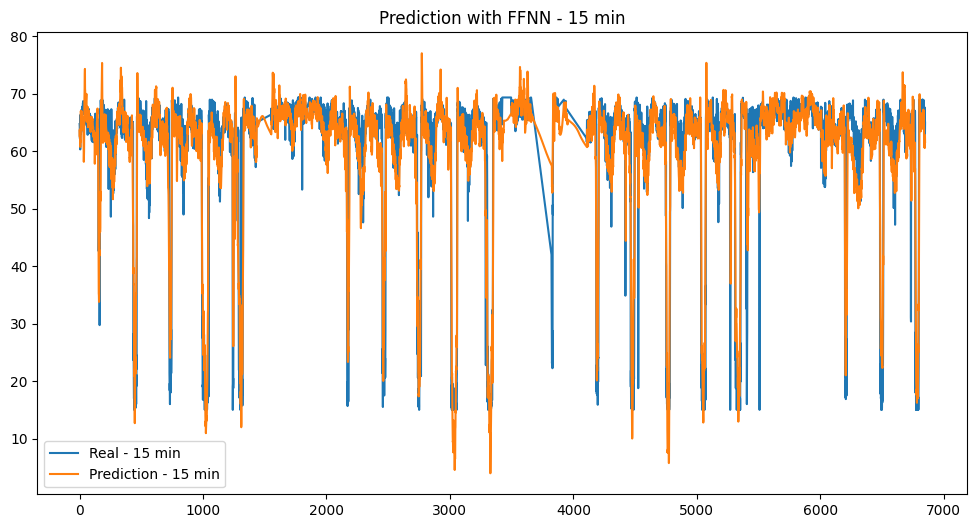

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:, 2, 0], label='Real - 15 min')  # Sensor 1, horizonte 15 minutos
plt.plot(pred_15[:, 0], label='Prediction - 15 min')
plt.title('Prediction with FFNN - 15 min')
plt.legend()
plt.show()

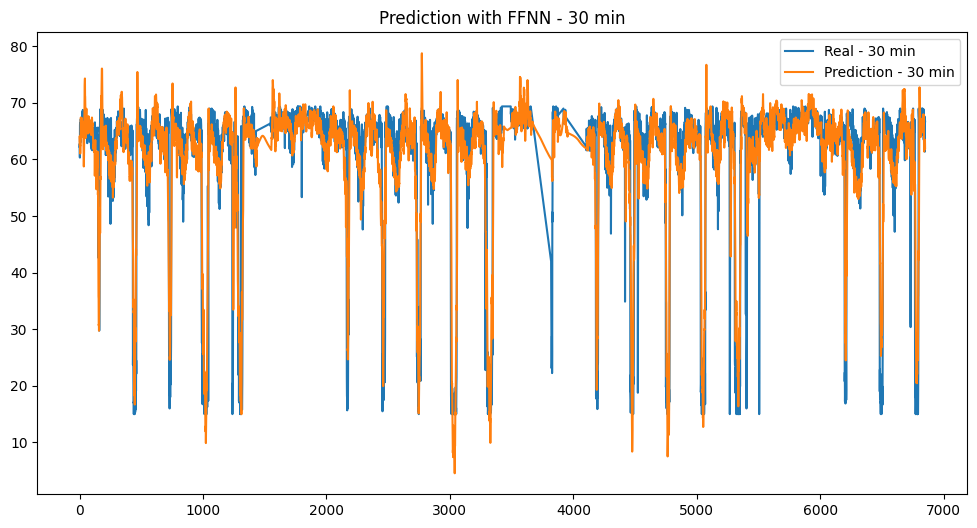

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:, 5, 0], label='Real - 30 min')  # Sensor 1, horizonte 30 minutos
plt.plot(pred_30[:, 0], label='Prediction - 30 min')
plt.title('Prediction with FFNN - 30 min')
plt.legend()
plt.show()
